In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

In [21]:
def plot_results(result_dict):
    fig, ax = plt.subplots(figsize=(6, 5))

    dataset = result_dict["dataset"]
    task_type = result_dict["task_type"]

    ax.set_xlabel("Noise Level")
    perf_string = "Performance " + "RMSE" if task_type == "regression" else "ROC-AUC"
    ax.set_ylabel(perf_string)
    
    ax.set_title(dataset)

    strucs = result_dict["structure"]
    feats = result_dict["feature"]
    ts = list(strucs.keys())

    # Ensure the x-axis values are numeric and sorted
    ts = sorted([float(t) for t in ts])  # Convert keys to floats and sort them

    struc_means = [np.mean([float(val) for val in strucs[str(t)]]) for t in ts]
    struc_devs = [np.std([float(val) for val in strucs[str(t)]]) for t in ts]
    feat_means = [np.mean([float(val) for val in feats[str(t)]]) for t in ts]
    feat_devs = [np.std([float(val) for val in feats[str(t)]]) for t in ts]

    ax.errorbar(ts, struc_means, yerr=struc_devs, label="Structure", c = "black")
    ax.errorbar(ts, feat_means, yerr=feat_devs, label="Feature", c = "blue", linestyle = "dashed")

    # Format x-axis ticks
    ax.set_xticks(ts)  # Ensure all unique noise levels are shown
    ax.set_xticklabels([f"{t:.2f}" for t in ts])  # Format as two decimal places

    ax.legend()
    plt.savefig(f"figures/{dataset}-linear.png", dpi=600)


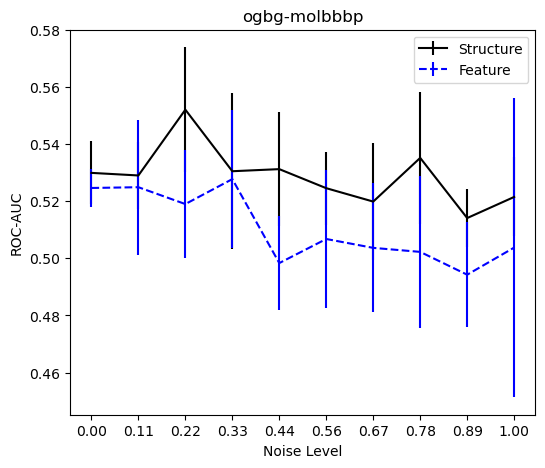

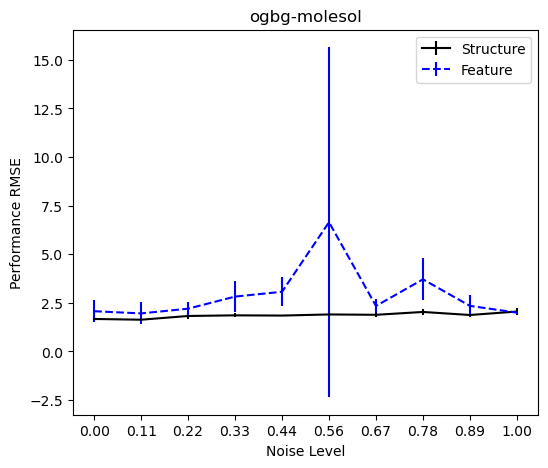

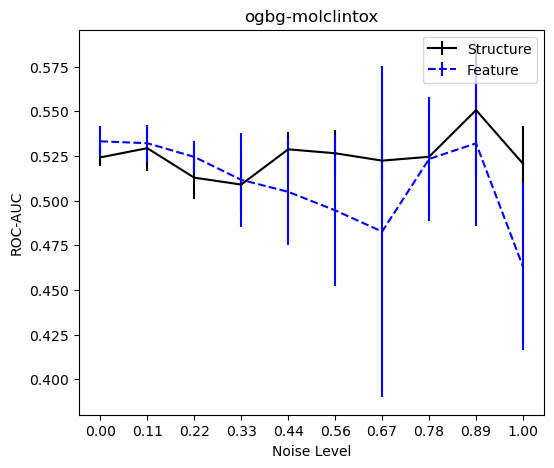

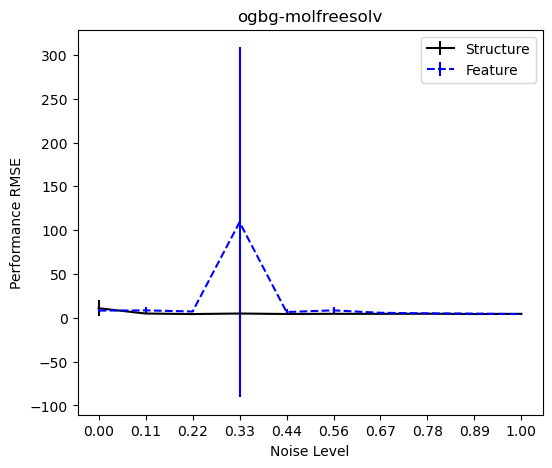

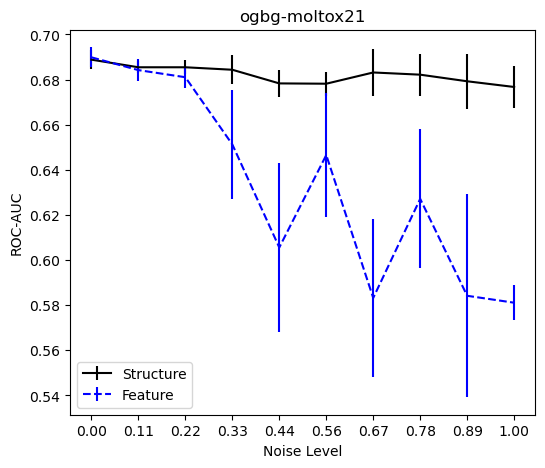

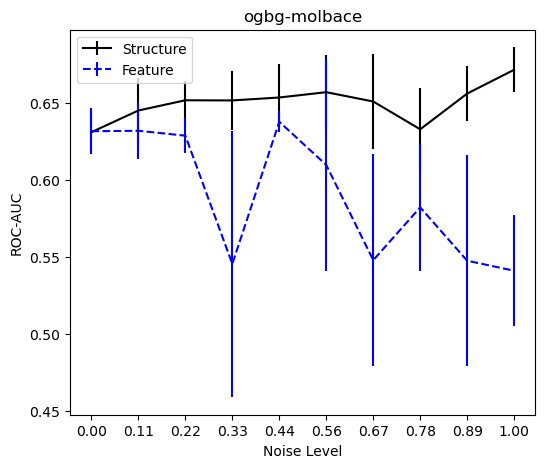

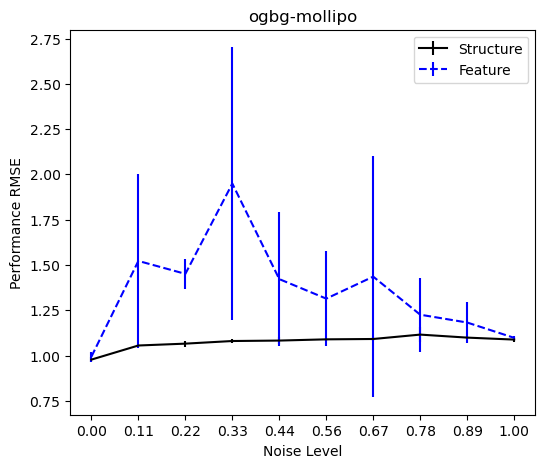

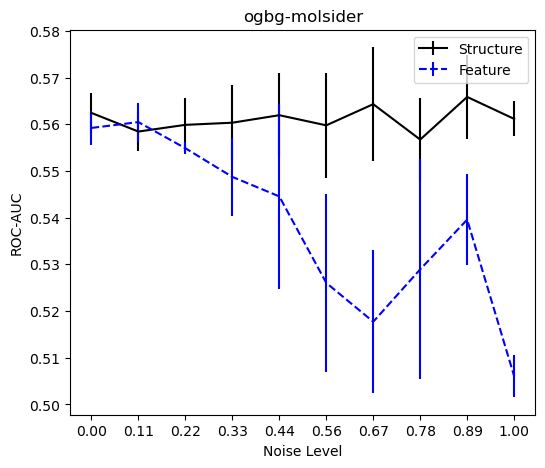

In [22]:
results_jsons = os.listdir("results-linear")
result_dicts = []
for result in results_jsons:
    with open(f"results-linear/{result}", "r") as f:
        dic = json.load(f)
    result_dicts.append(dic)

for result in result_dicts:
    plot_results(result)

In [23]:
from scipy.stats import spearmanr

def nncr(result_dict):
    dataset = result_dict["dataset"]
    strucs = result_dict["structure"]
    feats = result_dict["feature"]
    ts = list(strucs.keys())
    struc_means = [np.mean([float(val) for val in strucs[str(t)]]) for t in ts]
    struc_devs = [np.std([float(val) for val in strucs[str(t)]]) for t in ts]
    feat_means = [np.mean([float(val) for val in feats[str(t)]]) for t in ts]
    feat_devs = [np.std([float(val) for val in feats[str(t)]]) for t in ts]

    r_structure = np.abs(spearmanr(ts, struc_means)[0])
    r_feature = np.abs(spearmanr(ts, feat_means)[0])
    
    nncr = r_feature  / r_structure

    # print(f"r feature: {r_feature}\n r structure: {r_structure} nncr: {nncr}")

    return np.log10(nncr)

# for result in result_dicts:
#     print(result["dataset"])
#     print(nncr(result))

In [25]:
def nnd(result_dict):
    dataset = result_dict["dataset"]
    task = result_dict["task_type"]
    strucs = result_dict["structure"]
    feats = result_dict["feature"]
    ts = list(strucs.keys())
    struc_means = [np.mean([float(val) for val in strucs[str(t)]]) for t in ts]
    struc_devs = [np.std([float(val) for val in strucs[str(t)]]) for t in ts]
    feat_means = [np.mean([float(val) for val in feats[str(t)]]) for t in ts]
    feat_devs = [np.std([float(val) for val in feats[str(t)]]) for t in ts]

    if task == "classification":
        difference = np.array(feat_means) / np.mean(struc_means)
    else:
        difference = np.mean(struc_means) / np.array(feat_means)

    return np.log(np.sum(difference) / difference.shape[0])

def minmax_performance_structure(result_dict):
    dataset = result_dict["dataset"]
    task = result_dict["task_type"]
    strucs = result_dict["structure"]
    ts = list(strucs.keys())
    struc_means = [np.mean([float(val) for val in strucs[str(t)]]) for t in ts]

    # if task == "classification":
    return struc_means[0], struc_means[-1] # np.min(struc_means), np.max(struc_means)
    # else:
        # return np.max(struc_means), np.min(struc_means)

def minmax_performance_feature(result_dict):
    dataset = result_dict["dataset"]
    task = result_dict["task_type"]
    feats = result_dict["feature"]
    ts = list(feats.keys())
    feat_means = [np.mean([float(val) for val in feats[str(t)]]) for t in ts]

    # if task == "classification":
    return feat_means[0], feat_means[-1] # np.min(feat_means), np.max(feat_means)
    # else:
        # return np.max(feat_means), np.min(feat_means)

for result in result_dicts:
    print(result["dataset"])
    print(result["task_type"])
    print(f"nnd: {nnd(result)}")
    
    # print(f"nncr: {nncr(result)}")
    worse_structure, best_structure = minmax_performance_structure(result)
    print(worse_structure, best_structure)
    print(100 * np.abs(best_structure - worse_structure) / worse_structure)
    worse_feature, best_feature = minmax_performance_feature(result)
    print(worse_feature, best_feature)
    print(100 * np.abs(best_feature - worse_feature) / worse_feature)
    print("\n")

ogbg-molbbbp
classification
nnd: -0.03513079699011068
0.5299189814814815 0.5214891975308642
1.5907684467256467
0.524633487654321 0.5037615740740741
3.978379968378878


ogbg-molesol
regression
nnd: -0.321235030395454
1.6708943799999996 2.05248854
22.837718803028153
2.0695497 1.99686716
3.5119978031936108


ogbg-molclintox
classification
nnd: -0.02838542136480007
0.5241592812706356 0.5206339276404963
0.6725729670556116
0.5331583428909046 0.4629619782434921
13.166138274568109


ogbg-molfreesolv
regression
nnd: -0.2689516245789565
10.858737000000001 4.50308868
58.530272167011695
8.171109159999999 4.20479322
48.54072883295074


ogbg-moltox21
classification
nnd: -0.07419279406332968
0.6888307728307459 0.6767234246967316
1.7576665578193011
0.689865798630082 0.5810891594560881
15.767797068647239


ogbg-molbace
classification
nnd: -0.09644801110098146
0.6310206920535559 0.6715701617110067
6.426012675668209
0.6316466701443227 0.541018953225526
14.347850024775651


ogbg-mollipo
regression
nnd: -0